In [1]:
import geopandas
import starepandas
import pystare
import numpy
import matplotlib.pyplot as plt
import pickle
import pandas
import glob

In [2]:
# We set level to 15 because that appears to be matching VNP02 nadir resolution 
level = 15
country = 'Dominica'

In [3]:
adm2 = pandas.read_pickle('covers/caribbean_staredf_l{}.pickle'.format(level))

In [10]:
adm0 = pandas.read_pickle('covers/countries_staredf_l{}.pickle'.format(level))

<AxesSubplot:>

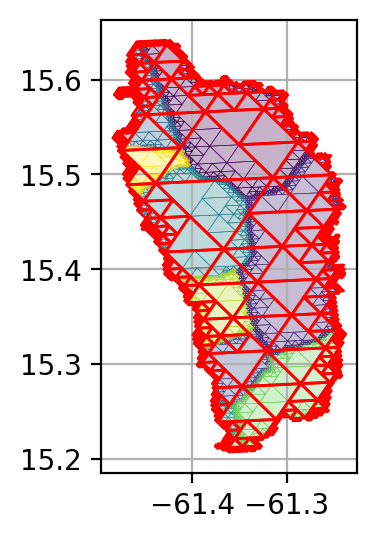

In [5]:
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.grid(True)

adm2[adm2['ADM0_NAME']==country].plot(ax=ax, trixels=False,  alpha=0.3, column='ADM2_CODE')
adm2[adm2['ADM0_NAME']==country].plot(ax=ax, trixels=True, boundary=True, linewidth=0.2, column='ADM2_CODE')
adm0[adm0['ADM0_NAME']==country].plot(ax=ax, trixels=True, color='red', linewidth=1)

# Load catalog and find intersecting granules

In [8]:
catalog_vnp03 = pandas.read_pickle('catalogs/catalog_vnp03.pickle')
catalog_vnp03.set_stare('stare_cover', inplace=True)

In [9]:
cover_sids = adm0[adm0['ADM0_NAME']==country]['stare'].iloc[0]

intersects = catalog_vnp03.stare_intersects(cover_sids, n_workers=50)
intersecting = catalog_vnp03[intersects]
intersecting.head()

,begining,ending,granule_path,sidecar_path,stare_cover
5,2019-08-15T06:00:00.000Z,2019-08-15T06:06:00.000Z,/tablespace/caribbean/VNP03DNB/VNP03DNB.A20192...,/tablespace/caribbean/VNP03DNB/VNP03DNB.A20192...,"[2485986994308513795, 2513008592072736771, 266..."
8,2020-05-08T05:54:00.000Z,2020-05-08T06:00:00.000Z,/tablespace/caribbean/VNP03DNB/VNP03DNB.A20201...,/tablespace/caribbean/VNP03DNB/VNP03DNB.A20201...,"[2485986994308513795, 2499497793190625284, 251..."
11,2014-02-24T05:24:00.000Z,2014-02-24T05:30:00.000Z,/tablespace/caribbean/VNP03DNB/VNP03DNB.A20140...,/tablespace/caribbean/VNP03DNB/VNP03DNB.A20140...,"[2494994193563254787, 2513008592072736771, 248..."
20,2013-03-29T05:42:00.000Z,2013-03-29T05:48:00.000Z,/tablespace/caribbean/VNP03DNB/VNP03DNB.A20130...,/tablespace/caribbean/VNP03DNB/VNP03DNB.A20130...,"[2504001392817995779, 2576058986855923715, 310..."
27,2019-04-11T05:18:00.000Z,2019-04-11T05:24:00.000Z,/tablespace/caribbean/VNP03DNB/VNP03DNB.A20191...,/tablespace/caribbean/VNP03DNB/VNP03DNB.A20191...,"[2504001392817995779, 2576058986855923715, 245..."


# Read Granule

In [58]:
n = 0
geoloc_path = intersecting.iloc[n].granule_path
begining = intersecting.iloc[n].begining
ending = intersecting.iloc[n].ending

granule_path = starepandas.guess_companion_path(geoloc_path, 
                                                prefix='VNP02DNB',
                                                folder='/tablespace/caribbean/VNP02DNB/')


print(geoloc_path)
print(granule_path)

/tablespace/caribbean/VNP03DNB/VNP03DNB.A2019227.0600.001.2019227123342.nc
/tablespace/caribbean/VNP02DNB/VNP02DNB.A2019227.0600.001.2019227124352.nc


In [12]:
vnp02 = starepandas.read_granule(granule_path, sidecar=False, read_latlon=False)
vnp03 = starepandas.read_granule(geoloc_path, sidecar=True, read_latlon=True)

In [13]:
vnp02 = vnp03.join(vnp02)
vnp02.head()

,lat,lon,stare,moon_illumination_fraction,land_water_mask,quality_flag,DNB_observations,DNB_quality_flags
0,23.112310,-80.106613,3128132001189645422,99.839996,6,0,-9.999000e+02,256
1,23.111811,-80.098763,3128131894881147342,99.839996,6,0,2.629899e-09,0
2,23.111313,-80.090919,3128131898677762478,99.839996,6,0,1.835751e-09,0
3,23.110815,-80.083084,3128131844775414670,99.839996,6,0,2.232825e-09,0
4,23.110317,-80.075256,3128131830591011214,99.839996,6,0,3.225510e-09,0


# Filter according to masks and flags

## DNB_quality_flags
- 1     Substitute_Cal 
- 2     Out_of_Range 
- 4     Saturation 
- 8     Temp_not_Nominal 
- 16    Stray_light 
- 256   Bowtie_Deleted 
- 512   Missing_EV 
- 1024  Cal_Fail 
- 2048  Dead_Detector

## land_water_mask
- 0 Shallow Ocean; Ocean pixel with depth < 160 ft
- 1 Land; Land detected
- 2 Shoreline; Last land pixel before water
- 3 Inland Water;  Open surface water on continent
- 4 Ephemeral Water; Not populated in this version
- 5 Deep Inland Water; Inland water > 160 ft
- 6 Moderate Ocean; Ocean pixel with depth > 160 ft but <400 ft
- 7 Deep Ocean; Ocean pixel with depth > 400 ft

## quality_flag (geolocation)
- 1: Input_invalid
- 2: Pointing_bad
- 3: Terrain_bad

In [14]:
mask = vnp02['DNB_quality_flags'] == 0
mask &= vnp02['quality_flag'] == 0
mask &= (vnp02['land_water_mask'] == 1) | (vnp02['land_water_mask'] == 2)

In [15]:
selected = vnp02[mask]
print('{} %'.format(round(selected.size/vnp02.size*100)))

40 %


# Pulling out data intersecting our Country

In [42]:
cover_sids = adm0[adm0['ADM0_NAME']==country]['stare'].iloc[0]

In [43]:
intersects = selected.stare_intersects(cover_sids, n_workers=10)
intersected = selected[intersects.values]
intersected.head()

,lat,lon,stare,moon_illumination_fraction,land_water_mask,quality_flag,DNB_observations,DNB_quality_flags,geometry
3119847,15.636556,-61.441116,2521991340185305518,99.839996,2,0,2.589059e-08,0,POINT (-61.44112 15.63656)
3119848,15.635362,-61.434650,2521990252424963822,99.839996,2,0,2.205102e-08,0,POINT (-61.43465 15.63536)
3119849,15.634096,-61.427811,2521990341239696910,99.839996,2,0,2.026946e-08,0,POINT (-61.42781 15.63410)
3119850,15.632756,-61.420567,2521990312548741198,99.839996,2,0,1.821146e-08,0,POINT (-61.42057 15.63276)
3123909,15.634911,-61.461906,2521894433565919886,99.839996,2,0,1.704566e-08,0,POINT (-61.46191 15.63491)


<AxesSubplot:>

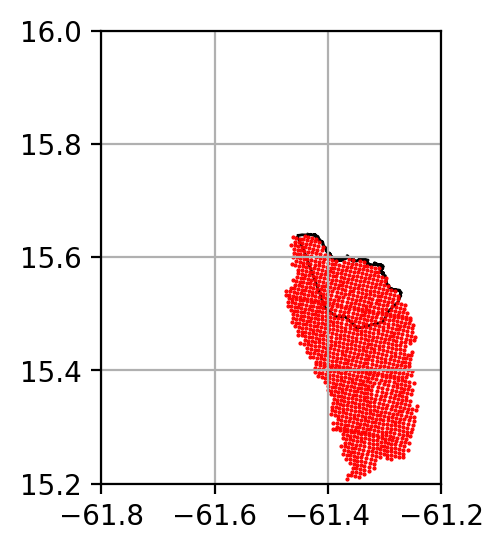

In [41]:
fig, ax = plt.subplots(figsize=(3,3), dpi=200)
ax.grid(True)

ax.set_ylim(15.2, 16)
ax.set_xlim(-61.8, -61.2)


pts = geopandas.points_from_xy(intersected.lon, intersected.lat)
intersected = intersected.set_geometry(pts)

adm0[adm0['ADM0_NAME']==country].plot(ax=ax, trixels=False, color='w', edgecolor='black')
intersected.plot(ax=ax, color='r', alpha=1, marker='.', markersize=1)

# Now we get the value per ADM2

In [70]:
adm2_country = adm2[adm2['ADM0_NAME']==country]

df = pandas.DataFrame()
for index, row in adm2_country.iterrows():        
    in_adm2 = intersected.stare_intersects(row.stare)
    mean = intersected[in_adm2.values].mean()    
    df = df.append({'start': begining, 
                    'adm0': row.ADM0_CODE,
                    'adm2': row.ADM2_CODE, 
                    'avg_dnb': mean['DNB_observations'],
                    'moon': mean['moon_illumination_fraction']}, ignore_index=True)
    
df

,adm0,adm02,avg_dnb,moon,start
0,71.0,15283.0,1.641304e-08,99.839981,2019-08-15T06:00:00.000Z
1,71.0,15285.0,1.443533e-08,99.839981,2019-08-15T06:00:00.000Z
2,71.0,15286.0,1.379427e-08,99.839981,2019-08-15T06:00:00.000Z
3,71.0,15287.0,1.338612e-08,99.839981,2019-08-15T06:00:00.000Z
4,71.0,15288.0,1.156713e-08,99.839981,2019-08-15T06:00:00.000Z
5,71.0,15289.0,1.116815e-08,99.839996,2019-08-15T06:00:00.000Z
6,71.0,15290.0,1.764841e-08,99.839989,2019-08-15T06:00:00.000Z
7,71.0,15291.0,1.398575e-08,99.839981,2019-08-15T06:00:00.000Z
8,71.0,15292.0,9.847798e-09,99.839989,2019-08-15T06:00:00.000Z
9,71.0,15284.0,1.761906e-08,99.839989,2019-08-15T06:00:00.000Z


# Load Cloudmask

## Cloud mask meaning
- 0 = cloudy
- 1 = probably cloudy 
- 2 = probably clear 
- 3 = confident clear
- -1 = no result